###### Input  : 48x48 pixel gray values (between 0 and 255)
###### Output : emotion -- anger=0, disgust=1, fear=2, happy=3, sad=4, surprise=5, neutral=6

In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization
#from keras import backend as K
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


In [2]:
learning_rate = 0.001
epochs_value = 12
batch_size_value = 32

seed = 123; np.random.seed(seed); tf.set_random_seed(seed)

In [3]:
# few constants, Image related
IMAGE_SIZE = 48; 
VALIDATION_PERCENT = 0.1  
IMAGE_LOCATION_NORM = IMAGE_SIZE / 2
dict_labels = {
    0:'anger', 
    1:'disgust', 
    2: 'fear', 
    3:'happy', 
    4: 'sad', 
    5: 'surprise', 
    6: 'neutral'}
NUM_LABELS = len(dict_labels)

In [4]:
def read_emotion_data(data_dir, train_filename, test_filename):

    train_filename = os.path.join(data_dir, train_filename)
    data_frame = pd.read_csv(train_filename)
    data_frame.head(2)

    # Extract image data
    data_frame['Pixels'] = data_frame['Pixels'].apply(lambda x: np.fromstring(x, sep=" ") / 255.0)
    data_frame = data_frame.dropna()

    train_images = np.vstack(data_frame['Pixels']).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
    train_images.shape

    # Extract image label data
    train_labels = keras.utils.to_categorical(data_frame['Emotion'], NUM_LABELS)
    #train_labels = data_frame['Emotion'].apply(create_onehot_label)
    #train_labels = np.vstack(train_labels).reshape(-1, NUM_LABELS)
    train_labels.shape
    train_labels[0]

    # Shuffle for better training and validation samples
    permutations = np.random.permutation(train_images.shape[0])
    train_images = train_images[permutations]
    train_labels = train_labels[permutations]

    # Extract train and validation samples
    validation_percent = int(train_images.shape[0] * VALIDATION_PERCENT)
    validation_images = train_images[:validation_percent]
    validation_labels = train_labels[:validation_percent]
    train_images = train_images[validation_percent:]
    train_labels = train_labels[validation_percent:]

    # Reading test.csv
    test_filename = os.path.join(data_dir, test_filename)
    data_frame = pd.read_csv(test_filename)
    data_frame['Pixels'] = data_frame['Pixels'].apply(lambda x: np.fromstring(x, sep=" ") / 255.0)
    data_frame = data_frame.dropna()
    test_images = np.vstack(data_frame['Pixels']).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

    return train_images, train_labels, validation_images, validation_labels, test_images
# end of read_emotion_data

### Load the data

In [5]:
train_data, train_labels, eval_data, eval_labels, test_images = read_emotion_data('', "train.csv", "test.csv")
train_data.shape, train_labels.shape, eval_data.shape, eval_labels.shape, test_images.shape

((3761, 48, 48, 1), (3761, 7), (417, 48, 48, 1), (417, 7), (1312, 48, 48, 1))

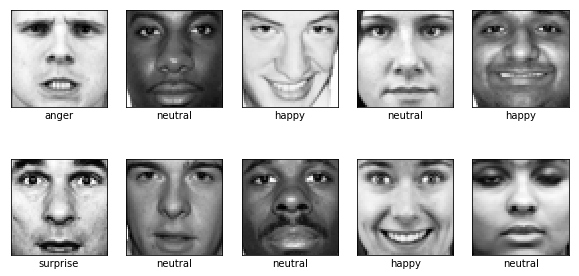

In [6]:
start = 70
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    face_image = train_data[i+start]
    plt.imshow(np.reshape(face_image, [48, 48]), cmap='Greys_r')
    plt.xlabel(dict_labels[np.argmax(train_labels[i+start])])

# Convert the data to numeric

In [7]:
train_data = train_data.astype('float32')
eval_data = eval_data.astype('float32')

print('Train samples: ', train_data.shape[0],', Train data shape: ', train_data.shape)
print('Test samples: ', eval_data.shape[0])

Train samples:  3761 , Train data shape:  (3761, 48, 48, 1)
Test samples:  417


#### Train a CNN model

In [8]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#model.add(Dense(256, activation='relu'))
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(NUM_LABELS, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 44, 32)        832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 20, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 64)        0         
__________

### Define loss function, accuracy metrices

In [9]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=learning_rate),  metrics=['accuracy'])

### Train the model

In [10]:
training_model = model.fit(train_data, train_labels, batch_size=batch_size_value, epochs=epochs_value, verbose=1, validation_data=(eval_data, eval_labels))

Train on 3761 samples, validate on 417 samples
Epoch 1/12
3761/3761 [==============================] - 75s 20ms/step - loss: 1.0605 - acc: 0.6389 - val_loss: 2.6322 - val_acc: 0.2926
Epoch 2/12
3761/3761 [==============================] - 38s 10ms/step - loss: 0.5781 - acc: 0.7950 - val_loss: 1.0969 - val_acc: 0.5731
Epoch 3/12
3761/3761 [==============================] - 39s 10ms/step - loss: 0.4234 - acc: 0.8625 - val_loss: 0.6855 - val_acc: 0.7410
Epoch 4/12
3761/3761 [==============================] - 38s 10ms/step - loss: 0.3143 - acc: 0.8918 - val_loss: 0.6672 - val_acc: 0.7794
Epoch 5/12
3761/3761 [==============================] - 39s 10ms/step - loss: 0.2521 - acc: 0.9165 - val_loss: 0.7458 - val_acc: 0.7314
Epoch 6/12
3761/3761 [==============================] - 39s 10ms/step - loss: 0.1794 - acc: 0.9410 - val_loss: 0.7322 - val_acc: 0.7434
Epoch 7/12
3761/3761 [==============================] - 39s 10ms/step - loss: 0.1672 - acc: 0.9479 - val_loss: 0.8607 - val_acc: 0.7266
E

## Evaluate the model

In [11]:
score = model.evaluate(eval_data, eval_labels, verbose=1)
print('Eval loss:', score[0])
print('Eval accuracy:', score[1]) 
training_model.history['acc'], training_model.history['val_acc']

417/417 [==============================] - 2s 6ms/step
Eval loss: 0.512310601963368
Eval accuracy: 0.8249400479616307


([0.6389258176809421,
  0.7950013294653574,
  0.862536559489077,
  0.8917841000526517,
  0.916511566072853,
  0.9409731454558906,
  0.9478862005102923,
  0.9614464238234512,
  0.9678277053975006,
  0.9747407604677504,
  0.9752725339005583,
  0.9750066471683063],
 [0.29256594724220625,
  0.5731414868105515,
  0.7410071942446043,
  0.7793764988009593,
  0.7314148681055156,
  0.7434052757793765,
  0.7266187050359713,
  0.7697841726618705,
  0.8249400479616307,
  0.8033573141486811,
  0.7601918465227818,
  0.8249400479616307])

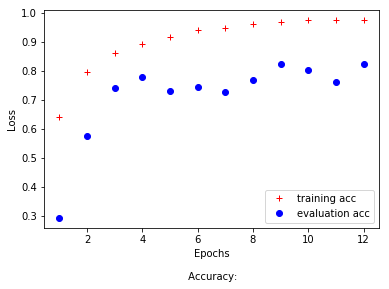

In [14]:
plt.plot(range(1,epochs_value+1), training_model.history['acc'], 'r+', label='training acc')
plt.plot(range(1,epochs_value+1), training_model.history['val_acc'], 'bo', label='evaluation acc')
plt.xlabel('Epochs\n\n Accuracy:')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Making Predictions

In [ ]:
predictions = model.predict(x=eval_data)